## Imports

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

# Processing Optimal results

In [3]:
all_players = pd.read_csv("../data/optim-data/0_selection_players.csv", index_col=0)
n_players = all_players.shape[0]

with open("optim_solution.json", "r") as fp:
    solution = json.load(fp)
    fp.close()

solution_variables = solution['CPLEXSolution']['variables']
solution_variables = [(x['name'], float(x['value'])) for x in solution_variables]

In [4]:
def get_players(variables, identifier):
    # assign, lentout, borrowed
    players = [x[0] for x in variables if identifier in x[0]]
    players = [x.split("_")[1:] for x in players]
    
    return players

def get_player_info(all_players, players, info):
    return [all_players.loc[int(i), info] for i in players]

assigned = pd.DataFrame(get_players(solution_variables, 'assign'), columns = ['Player', 'Year'])
lentout = pd.DataFrame(get_players(solution_variables, 'lentout'), columns = ['Player', 'Year'])
borrowed = pd.DataFrame(get_players(solution_variables, 'borrowed'), columns = ['Player', 'Year'])

players = sorted(np.unique(np.concatenate([assigned.Player, lentout.Player, borrowed.Player])), key=lambda x: int(x))
player_name = get_player_info(all_players, players, 'Player')
ages = get_player_info(all_players, players, 'Age')
raritan = get_player_info(all_players, players, 'Raritan')
player_gk = get_player_info(all_players, players, 'GK')
player_fw = get_player_info(all_players, players, 'FW')
player_mf = get_player_info(all_players, players, 'MF')
player_df = get_player_info(all_players, players, 'DF')

In [5]:
def fill_assignment(assignment, variables, fill_val):
    
    for index, (playerid, year) in variables.iterrows():
        year_s = "Year" + str(year)
        assignment.loc[playerid, year_s] = fill_val
        
    return

years = ['Year' + str(x) for x in range(10)]
assignment = pd.DataFrame(np.full((10, len(players)), np.nan)).T
assignment.columns = years
assignment.index = players

fill_assignment(assignment, assigned, 'o')
fill_assignment(assignment, lentout, 'l')
fill_assignment(assignment, borrowed, 'b')

assignment

,Year0,Year1,Year2,Year3,Year4,Year5,Year6,Year7,Year8,Year9
13,NaN,b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,l,l,l,NaN,l,l,l
33,NaN,NaN,NaN,b,NaN,NaN,NaN,NaN,NaN,NaN
48,b,NaN,NaN,b,b,b,b,b,NaN,b
68,l,l,l,NaN,NaN,NaN,l,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2617,NaN,NaN,NaN,NaN,l,NaN,l,NaN,NaN,NaN
2662,l,l,l,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b,NaN,NaN
2703,b,b,b,b,b,b,b,b,b,b


In [6]:
player_info = pd.DataFrame([players, player_name, ages, raritan, player_gk, player_fw, player_mf, player_df]).T
player_info.columns = ["PlayerID", "Player", "Age0", "Raritan", 'GK', 'FW', 'MF', 'DF']
player_info.index = players
player_info

,PlayerID,Player,Age0,Raritan,GK,FW,MF,DF
13,13,a.avako,25,0,0,0,1,0
15,15,a.baguma,18,1,0,1,0,0
33,33,a.gautier,23,0,0,0,0,1
48,48,a.khainza,21,0,1,0,0,0
68,68,a.mtambo,28,1,0,0,0,1
...,...,...,...,...,...,...,...,...
2617,2617,y.thungu,22,1,0,0,0,1
2662,2662,z.kakai,26,1,0,0,1,1
2684,2684,z.nabaweesi,18,0,0,1,0,0
2703,2703,z.rojas,21,0,0,0,0,1


In [8]:
player_selection = player_info.join(assignment, on='PlayerID')
player_selection
player_selection.to_excel('selection.xlsx')


# Visualising Results

In [9]:
player_assignment_year = [player_selection.loc[:, year_s] for year_s in years]

C:\Users\yunwa\AppData\Local\Temp\ipykernel_3820\391399325.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(abs(tick)) for tick in ticks])


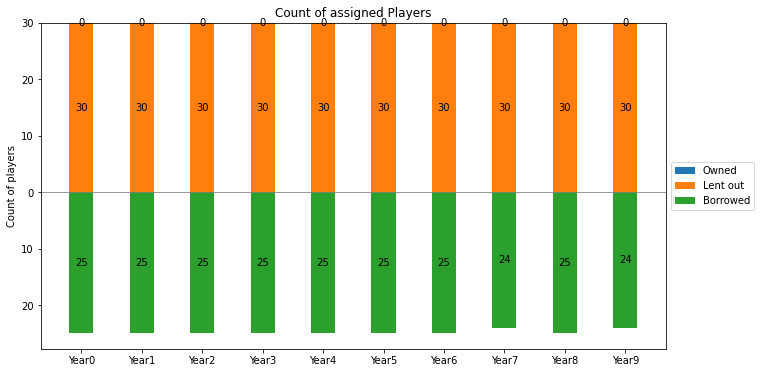

In [10]:
player_counts_year = [(np.sum(x == "o"), np.sum(x == "l"), np.sum(x == "b")) for x in player_assignment_year]

owned = [x[0] for x in player_counts_year]
lent = [x[1] for x in player_counts_year]
borrowed = [-x[2] for x in player_counts_year]

width = 0.4

fig, ax = plt.subplots()

fig.set_figheight(6)
fig.set_figwidth(14)

p1 = ax.bar(years, owned, width, bottom=lent,label='Owned')
p2 = ax.bar(years, lent, width, label='Lent out')
p3 = ax.bar(years, borrowed, width, label='Borrowed')

ax.set_ylabel('Count of players')
ax.set_title('Count of assigned Players')
ax.axhline(0, color='grey', linewidth=0.8)

# Label with label_type 'center' instead of the default 'edge'
ax.bar_label(p1, label_type='center')
ax.bar_label(p2, label_type='center')
ax.bar_label(p3, label_type='center', labels=[-x for x in borrowed])

ticks =  ax.get_yticks()
# set labels to absolute values and with integer representation
ax.set_yticklabels([int(abs(tick)) for tick in ticks])
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


C:\Users\yunwa\AppData\Local\Temp\ipykernel_3820\2622120110.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(abs(tick)) for tick in ticks])


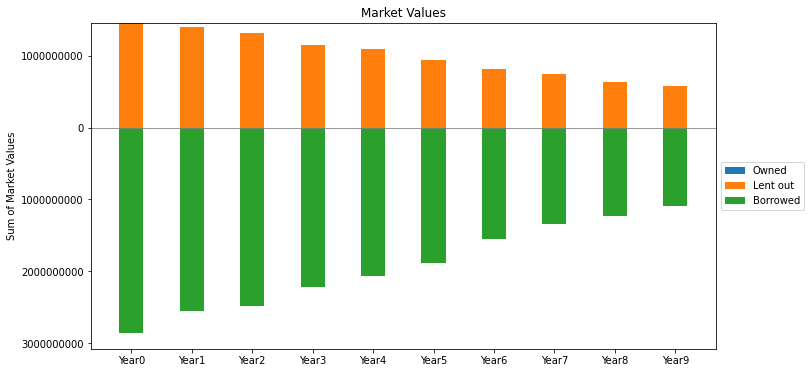

In [13]:
market_values = pd.read_csv("../data/optim-data/0_selection_mv.csv", index_col=0,).drop(['player_id', 'trial'], axis=1).values
n_time = market_values.shape[1]
n_trials = int(market_values.shape[0]/n_players)
market_values = np.mean(market_values.reshape((n_trials, n_players, n_time)), axis=0)

owned = [sum([market_values[int(playerid), year] for playerid, asm in row.iteritems() if asm == 'o']) for year, row in enumerate(player_assignment_year)]
lent = [sum([market_values[int(playerid), year] for playerid, asm in row.iteritems() if asm == 'l']) for year, row in enumerate(player_assignment_year)]
borrowed = [-sum([market_values[int(playerid), year] for playerid, asm in row.iteritems() if asm == 'b']) for year, row in enumerate(player_assignment_year)]

width = 0.4

fig, ax = plt.subplots()

fig.set_figheight(6)
fig.set_figwidth(14)

p1 = ax.bar(years, owned, width, bottom=lent,label='Owned')
p2 = ax.bar(years, lent, width, label='Lent out')
p3 = ax.bar(years, borrowed, width, label='Borrowed')

ax.set_ylabel('Sum of Market Values')
ax.set_title('Market Values')
ax.axhline(0, color='grey', linewidth=0.8)

# Label with label_type 'center' instead of the default 'edge'
# ax.bar_label(p1, label_type='center')
# ax.bar_label(p2, label_type='center')
# ax.bar_label(p3, label_type='center', labels=[-x for x in borrowed])

ticks =  ax.get_yticks()
# set labels to absolute values and with integer representation
ax.set_yticklabels([int(abs(tick)) for tick in ticks])
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()